178396
dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64


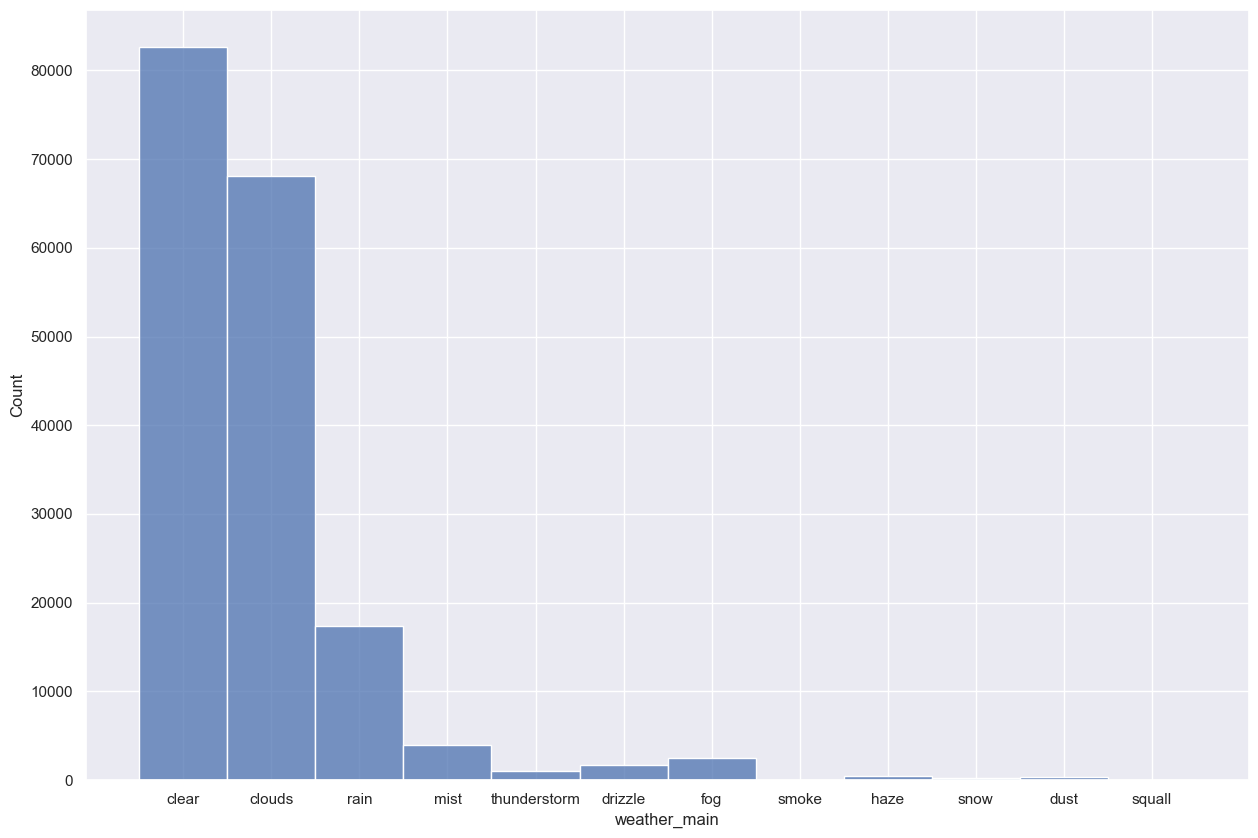

clear           0.463491
clouds          0.381483
rain            0.097485
mist            0.021906
fog             0.014047
drizzle         0.009664
thunderstorm    0.005835
haze            0.002438
dust            0.001945
snow            0.001513
smoke           0.000185
squall          0.000006
Name: weather_main, dtype: float64


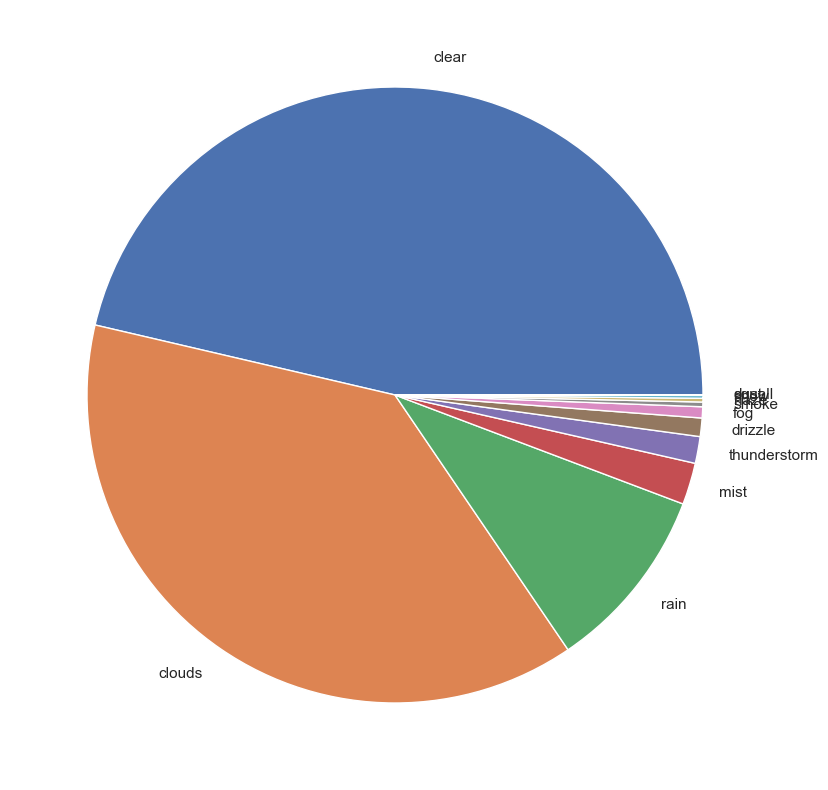

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('weather_features.csv')
print(df.shape[0])
print(df.isna().sum())

sns.histplot(df, x='weather_main')
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

print(df['weather_main'].value_counts(normalize=True))

labels = df['weather_main'].unique()
plt.pie(df['weather_main'].value_counts(), labels=labels)
plt.show()

In [102]:
hum = df[df['humidity'] == 0]
print(hum.value_counts().sum())
df = df[df['humidity'] > 0]
print(df.value_counts().sum())

63
178333


La temperatura più alta registrata è pari a:  315.6


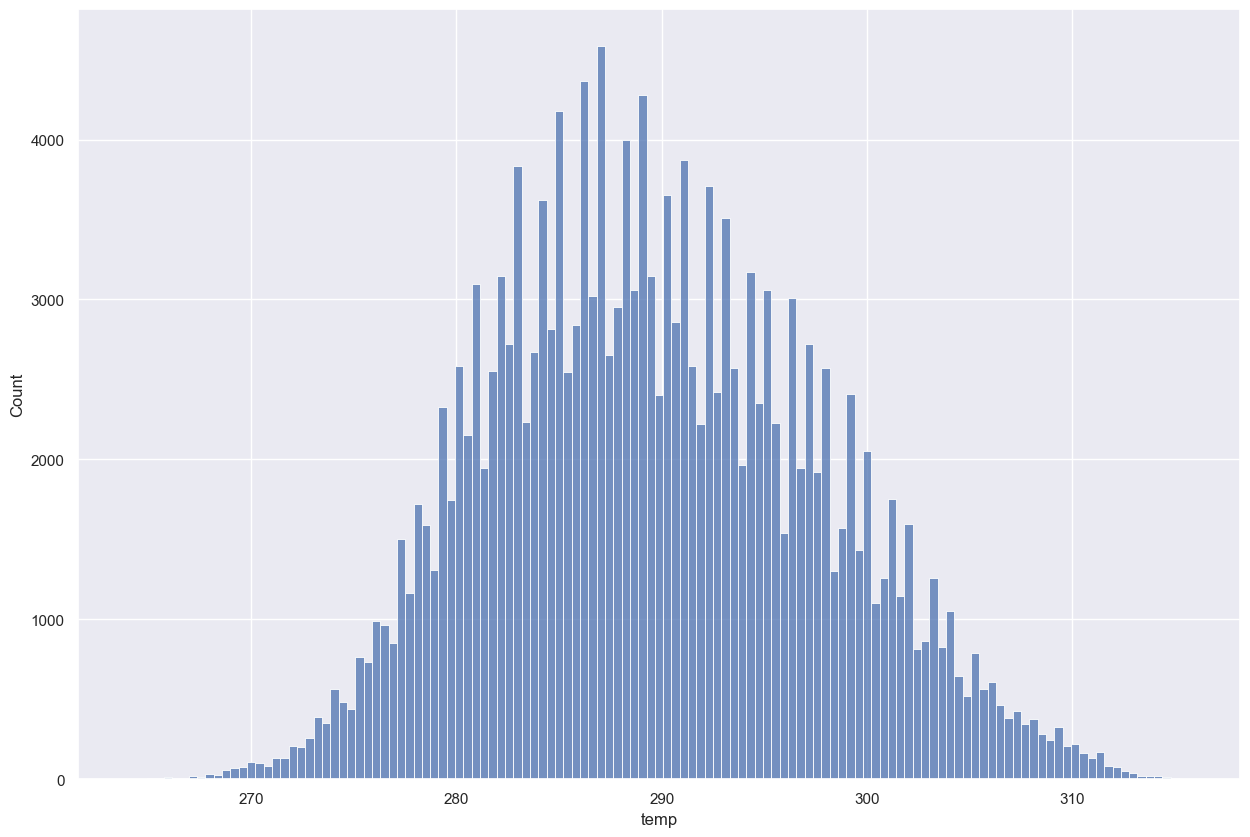

Seville       0.487999
Madrid        0.290938
Valencia      0.131225
 Barcelona    0.051817
Bilbao        0.038022
Name: city_name, dtype: float64


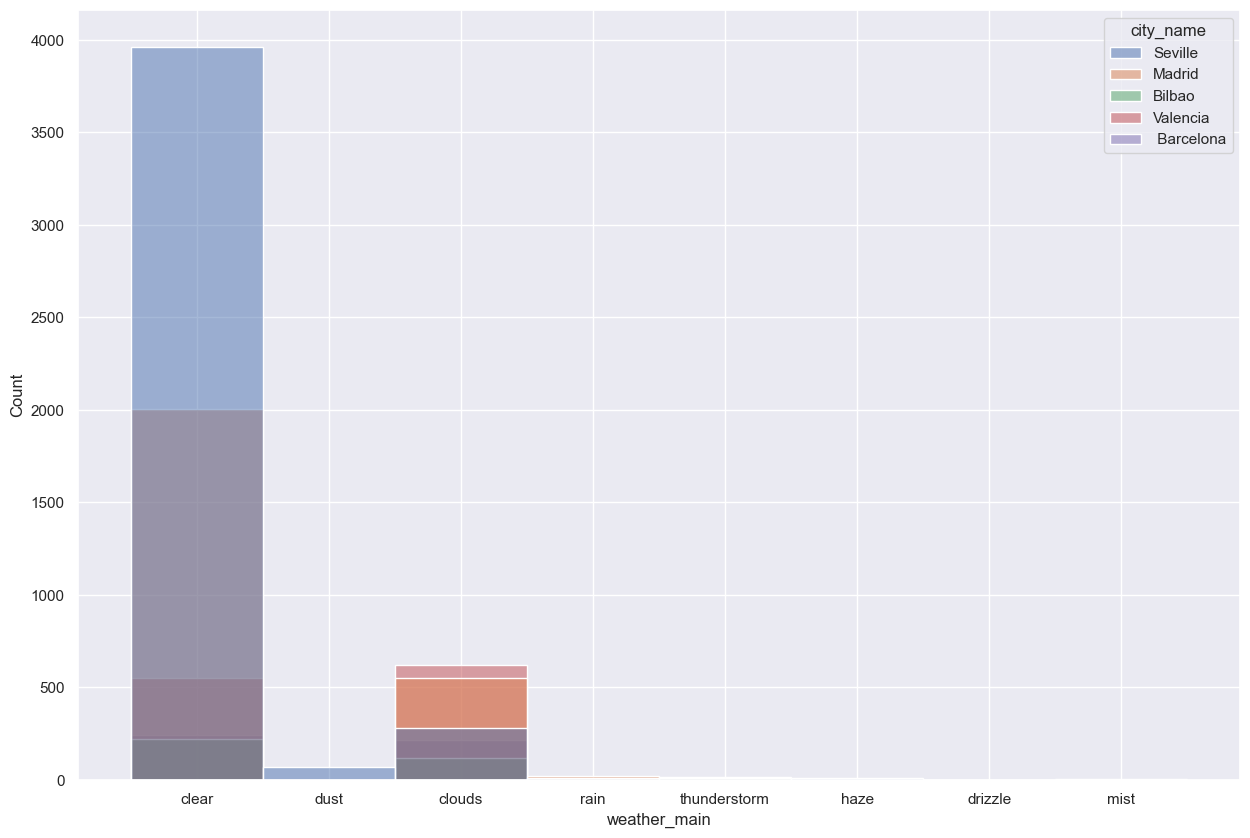

In [103]:
max_temp = df.loc[df['temp'].idxmax()]
print('La temperatura più alta registrata è pari a: ', max_temp['temp'])

sns.histplot(df, x='temp')
plt.show()

df_5 = df.sort_values(by=['temp'], ascending=False)
perc = int(df.shape[0] * 0.05)
df_5 = df_5[:perc]
print(df_5['city_name'].value_counts(normalize=True))

sns.histplot(df_5, x='weather_main', hue='city_name')
plt.show()

In [104]:
import numpy as np

freezing_temp = 273.15
df_snow = df[df['weather_main'] == 'snow']
df_temp = pd.DataFrame(np.where(df_snow['temp'] <= freezing_temp, True, False), columns=['temp'])
print(df_temp.value_counts())

temp 
False    251
True      17
dtype: int64


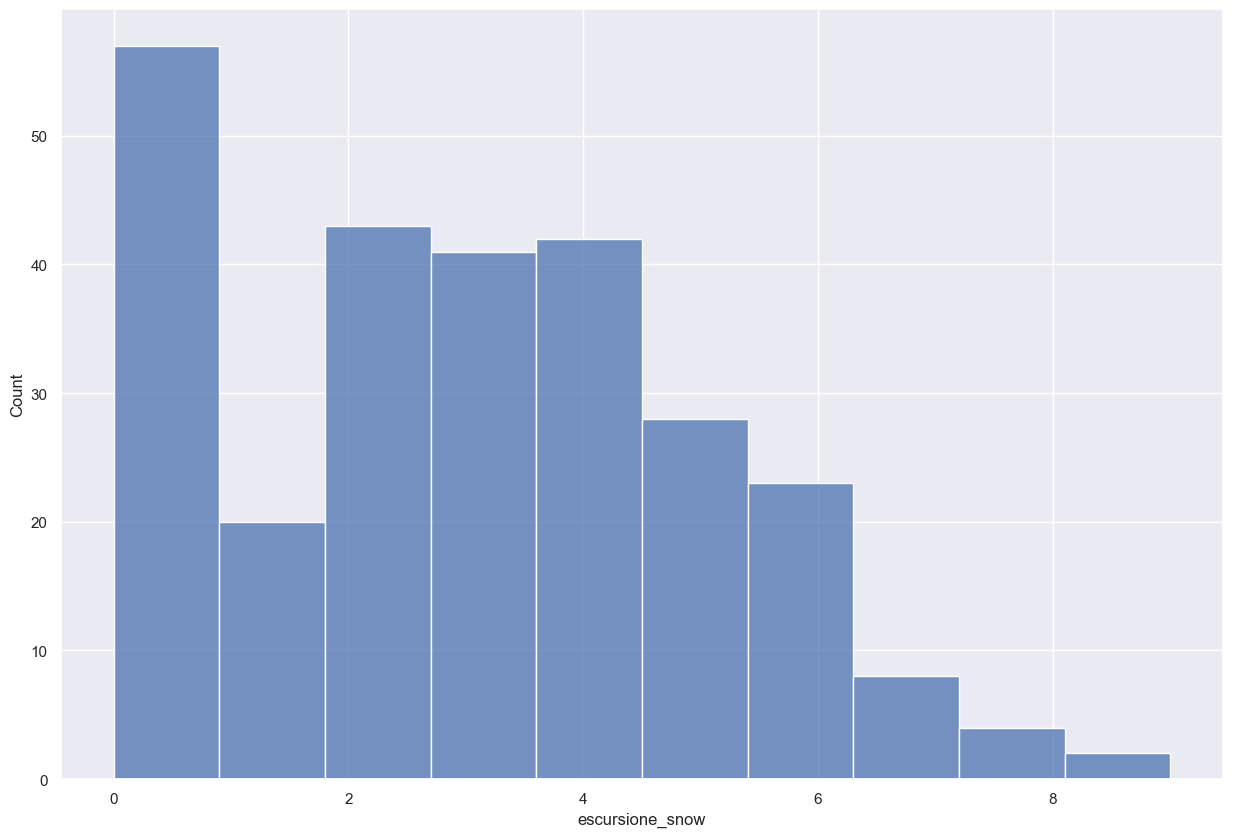

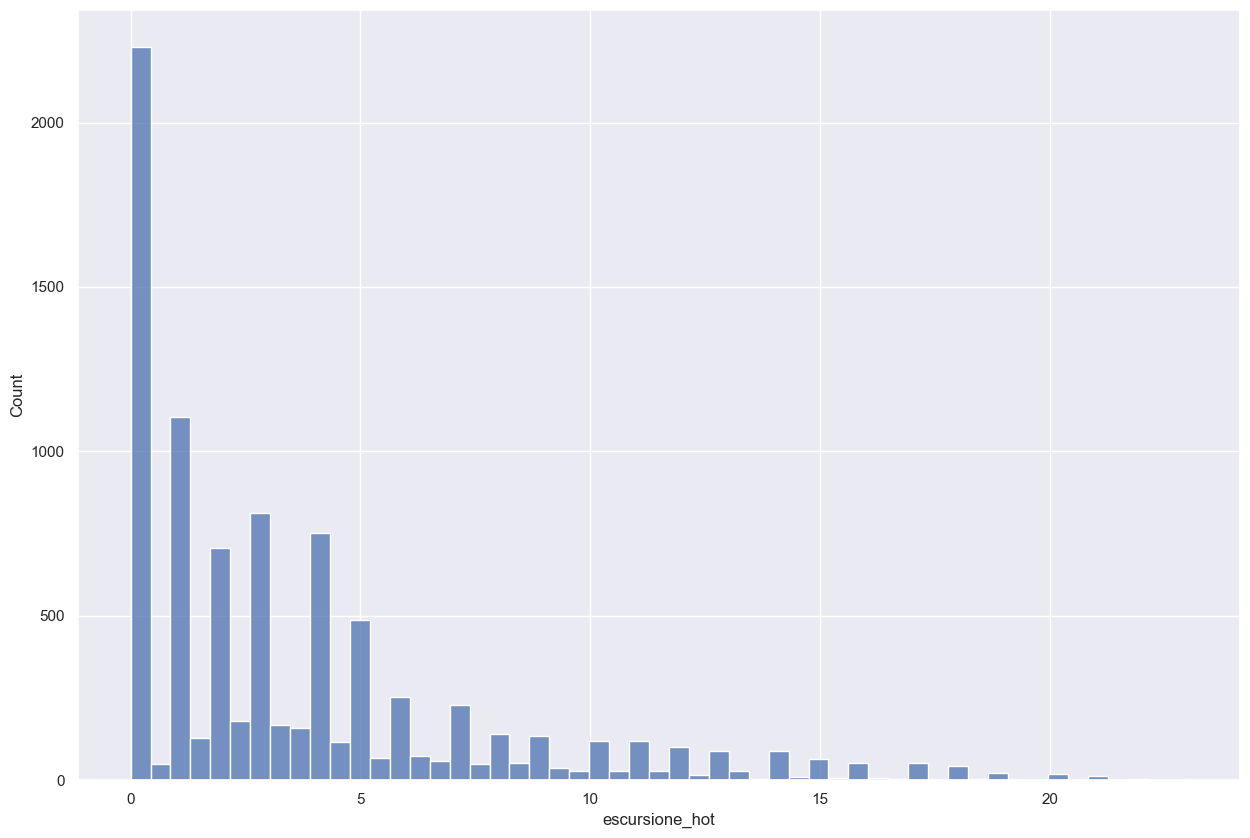

In [105]:
df_snow['escursione_snow'] = df_snow['temp_max'] - df_snow['temp_min']
df_5['escursione_hot'] = df_5['temp_max'] - df_5['temp_min']

sns.histplot(df_snow, x='escursione_snow')
plt.show()
sns.histplot(df_5, x='escursione_hot')
plt.show()

Decision Tree: (0.6341438805367773, 0.9843689565290507)
Logistic Regression: (0.47899640130494736, 0.48129992432523333)


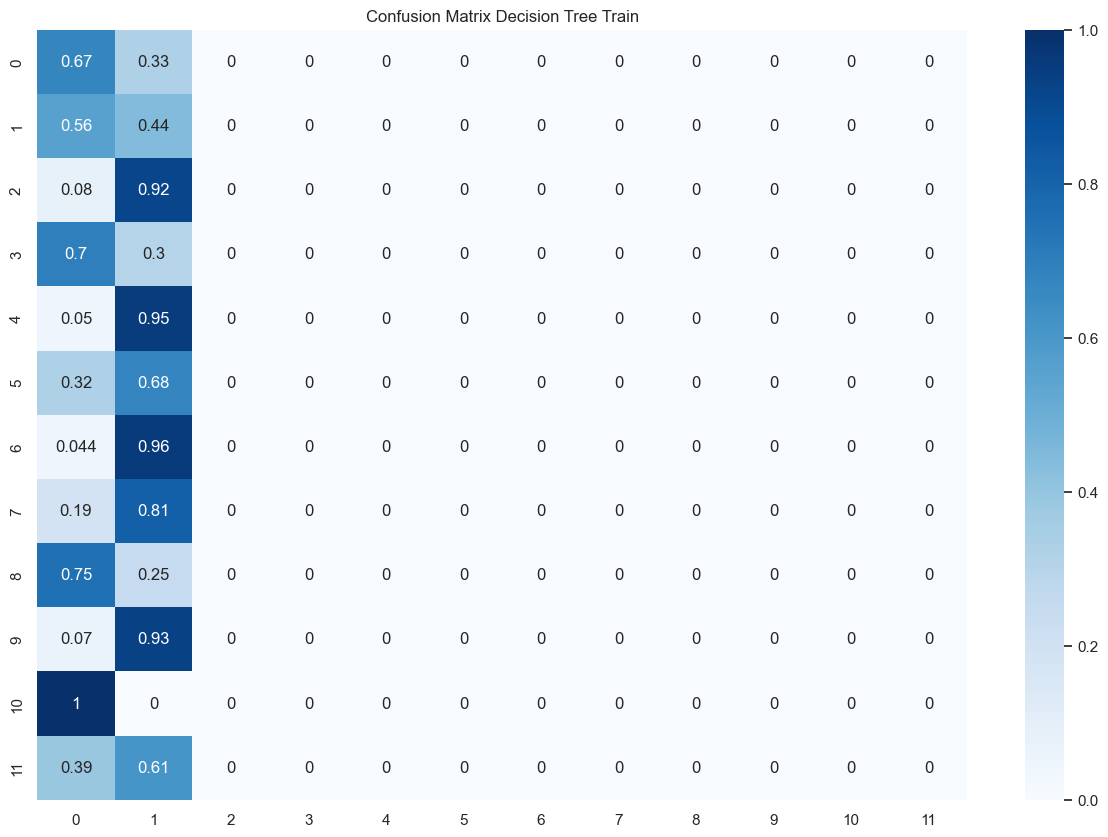

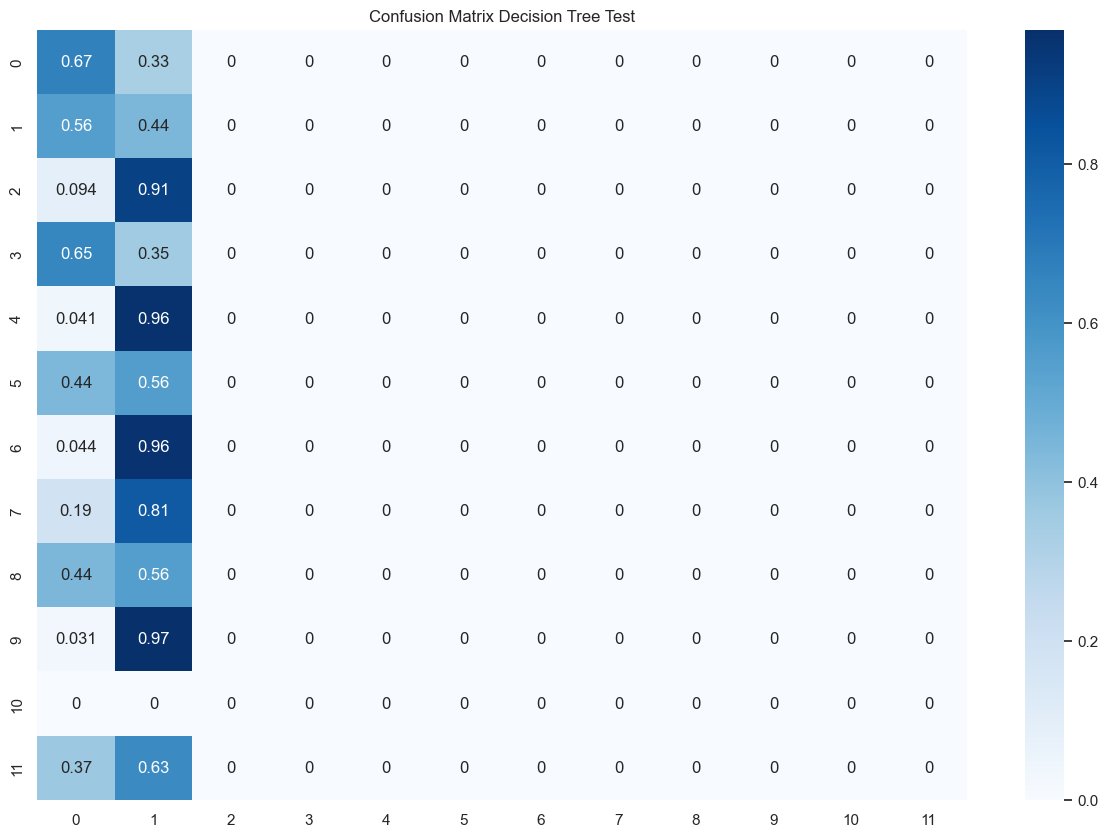

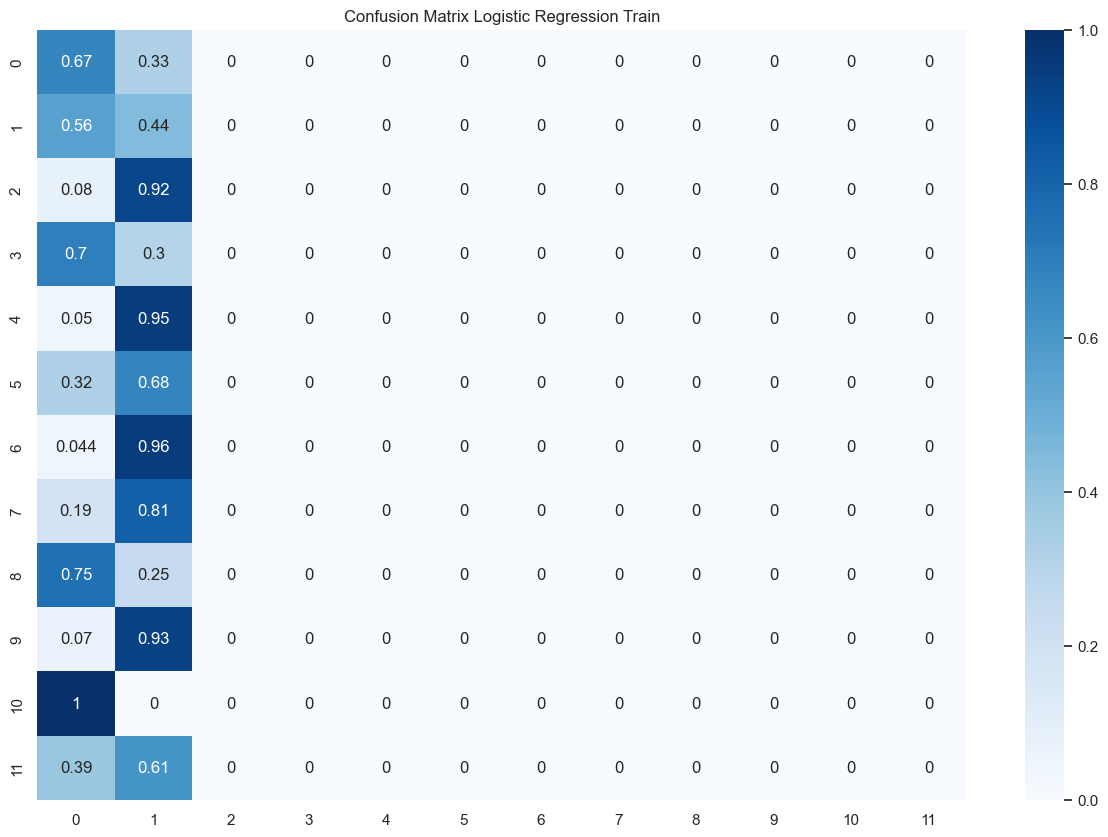

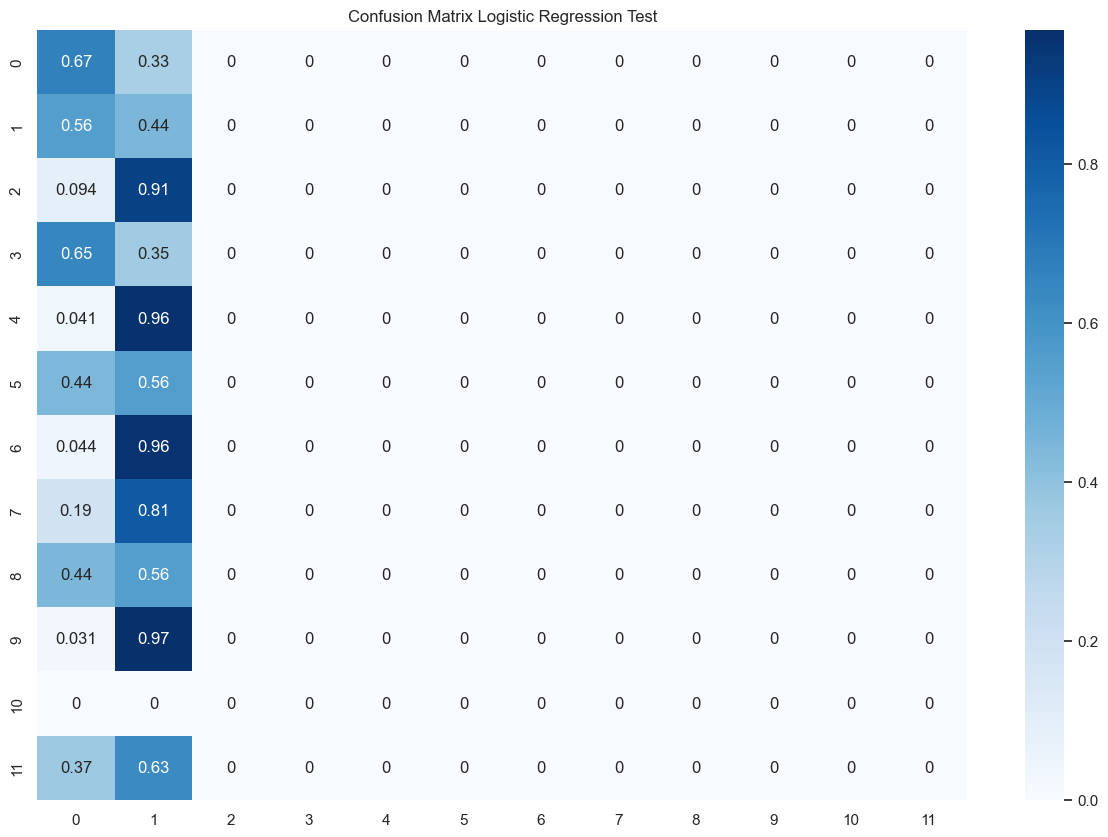

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('weather_features.csv')
df.drop(["dt_iso","city_name","weather_description", "weather_icon","weather_id","clouds_all"], axis=1, inplace=True)

maps = {
    'clear': '0',
    'clouds': '1',
    'rain': '2',
    'mist': '3',
    'fog': '4',
    'drizzle': '5',
    'thunderstorm': '6',
    'haze': '7',
    'dust': '8',
    'snow': '9',
    'smoke': '10',
    'squall': '11'
}
df.replace('weather_main', maps, inplace=True)

y = df['weather_main']
X = df.drop(["weather_main"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=1/3, random_state=0)

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
test_prediction = tree.predict(X_test)
train_prediction = tree.predict(X_train)
print(f'Decision Tree: {accuracy_score(y_test, test_prediction), accuracy_score(y_train, train_prediction)}')

logreg = LogisticRegression()

logreg.fit(X_train,y_train)
test_prediction = logreg.predict(X_test)
train_prediction = logreg.predict(X_train)
print(f'Logistic Regression: {accuracy_score(y_test, test_prediction), accuracy_score(y_train, train_prediction)}')
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_prediction, normalize='true', labels=tree.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_prediction, normalize='true', labels=tree.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Test')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_prediction, normalize='true', labels=logreg.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_prediction, normalize='true', labels=logreg.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Test')
plt.show()

In [107]:
from sklearn.model_selection import cross_val_score

print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())
print('Accuracy Decision Tree con Cross Val ',cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.5207175070140321
Accuracy Decision Tree con Cross Val  0.4804035123452244


In [108]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()

temp = norm.fit_transform(X)
Xn = pd.DataFrame(temp, columns=norm.get_feature_names_out())
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=1/3, random_state=0)

tree = DecisionTreeClassifier()

tree.fit(Xn_train, yn_train)
test_prediction = tree.predict(Xn_test)
train_prediction = tree.predict(Xn_train)
print(f'Decision Tree: {accuracy_score(y_test, test_prediction), accuracy_score(y_train, train_prediction)}')

Decision Tree: (0.620135875962735, 0.9843689565290507)


In [115]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA

newFeature = FeatureUnion(transformer_list=[('pca', PCA(n_components=5))], verbose=True)

pipe = Pipeline(steps=[('pca', PCA(n_components=5)),
                       ('model', DecisionTreeClassifier())])

pipe.fit(X_train,y_train)
test_prediction = pipe.predict(X_test)
train_prediction = pipe.predict(X_train)
print(f'Decision Tree: {accuracy_score(y_test, test_prediction), accuracy_score(y_train, train_prediction)}')

Decision Tree: (0.5470689133286247, 0.9843689565290507)


In [110]:
from sklearn.model_selection import GridSearchCV

param = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_features' : ['sqrt', None],
    'model__min_samples_split' : [2,3,4],
    'pca__n_components' : [1,3,5]
}

gs = GridSearchCV(pipe, param, verbose=1)

gs.fit(X_train,y_train)
test_prediction = gs.predict(X_test)
train_prediction = gs.predict(X_train)

print(gs.best_params_)
print(f'Decision Tree: {accuracy_score(y_test, test_prediction), accuracy_score(y_train, train_prediction)}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'model__criterion': 'entropy', 'model__max_features': None, 'model__min_samples_split': 3, 'pca__n_components': 5}
Decision Tree: (0.5538627114653751, 0.9659883965357774)


In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

pipeline = Pipeline(steps=[('pca', PCA(n_components=5)),
                        ('model', LinearRegression())])
y_train = y_train.replace(maps)
y_test = y_test.replace(maps)
pipeline.fit(X_train, y_train)
test_prediction = pipeline.predict(X_test)
train_prediction = pipeline.predict(X_train)

print(f'Decision Tree: {mean_absolute_error(y_test, test_prediction), mean_absolute_error(y_train, train_prediction)}')

Decision Tree: (0.711272088402034, 0.7109728852902202)
